### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

### Carregamento dos dados

In [2]:
dataOriginal = pd.read_csv('new_Global_Superstore2.csv', index_col=0, comment='#') 
df = dataOriginal 

### Tratamento dos dados

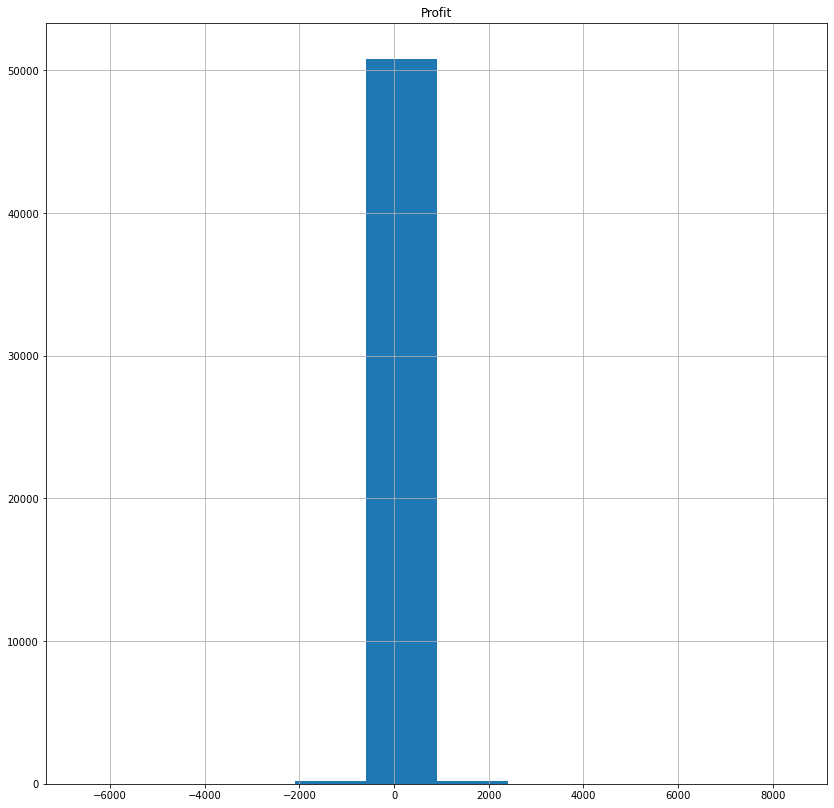

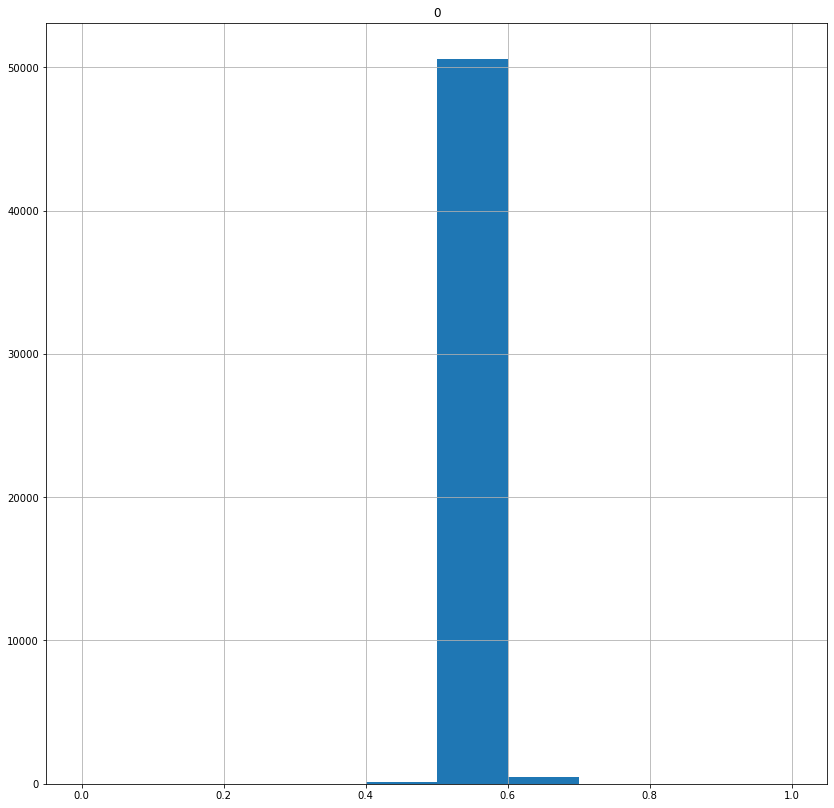

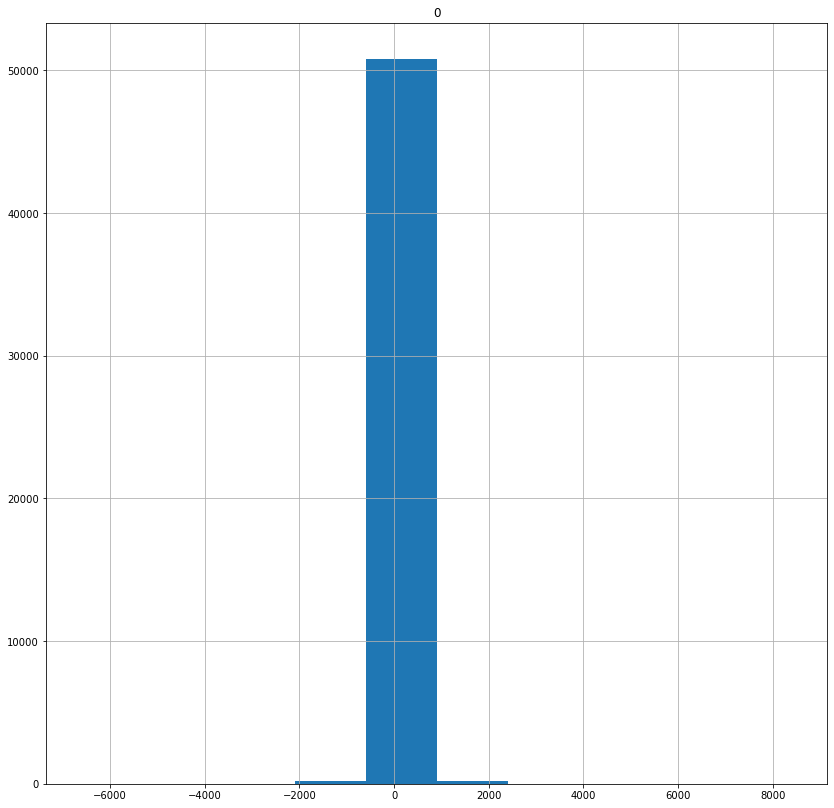

In [3]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
'''
Links:
https://stackoverflow.com/questions/44552031/sklearnstandardscaler-can-i-inverse-the-standardscaler-for-the-model-output
https://stackoverflow.com/questions/56936780/how-do-i-correctly-use-the-inverse-transform-method-when-using-powertransformer
'''

y = dataOriginal[['Profit']]
pd.DataFrame(y).hist(figsize=(14, 14));
df = dataOriginal

ss = StandardScaler()

ss.fit(df)
df = pd.DataFrame(ss.transform(df))

ss_y = StandardScaler()
ss_y.fit(y)
y = pd.DataFrame(ss_y.transform(y))
#y = ss_y.inverse_transform(pd.DataFrame(y))

pt = PowerTransformer()
pt.fit(df)
#df = pt.transform(df)
df = pd.DataFrame(pt.transform(df))

pt_y = PowerTransformer()
pt_y.fit(y)
#df = pt.transform(df)
y = pd.DataFrame(pt_y.transform(y))
#y = pt_y.inverse_transform(pd.DataFrame(y))


scaler = MinMaxScaler(feature_range = (0,1))
df = pd.DataFrame(scaler.fit_transform(df))
#df = pd.DataFrame(scaler.transform(df))
#df.hist(figsize=(14, 14));

#df.hist(figsize=(14, 14));

scaler_y = MinMaxScaler(feature_range = (0,1))
y = scaler_y.fit_transform(y)
#y = scaler_y.inverse_transform(pd.DataFrame(y))
pd.DataFrame(y).hist(figsize=(14, 14));

def unscale(value):
    value_res = value
    value_res = scaler_y.inverse_transform(pd.DataFrame(value_res))
    value_res = pt_y.inverse_transform(pd.DataFrame(value_res))
    value_res = ss_y.inverse_transform(pd.DataFrame(value_res))
 
    return value_res


y = unscale(y)
pd.DataFrame(y).hist(figsize=(14, 14));

#y = pd.DataFrame(scaler_y.transform(y))


### Neurónios

In [4]:
#dataset_MLP = dataset.drop(columns=['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code'])


#dataset_MLP = dataset_MLP.drop(['Order Priority', 'Market', "City", "Segment", "Ship Mode", "Ship Date"], axis=1)
#print(dataset_MLP.info())

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED = 2021

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


In [6]:
dataset_MLP = df

X_MLP = dataset_MLP.drop(8, axis=1)
y_MLP = dataset_MLP[[8]]

small_dataset = False
if small_dataset: 
    remove_n = 40000
    drop_indices = np.random.choice(dataset_MLP.index, remove_n, replace=False)
    dataset_MLP_subset = dataset_MLP.drop(drop_indices)
    X_MLP = dataset_MLP_subset.drop(8, axis=1)
    y_MLP = dataset_MLP_subset[[8]]


In [7]:

# Onde fui buscar algumas coisas:
# https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv


X_train, X_test, y_train, y_test = train_test_split(X_MLP, y_MLP, test_size=0.2, random_state=RANDOM_SEED)

number_columns = len(X_train.columns)#.count()
#print("Número de colunas: ", number_columns)

def build_model(activation='relu', learning_rate=0.01):
#create a sequential model (with three Layers - Last one is the output)
    model = Sequential()
    model.add(Dense(number_columns, input_dim=number_columns, activation=activation))
    model.add(Dense(6, activation=activation))
    model.add(Dense(1, activation='relu'))
  
     #compile the model
    #Define the Loss function, the otimizer and metrics to be used
    model. compile(
        loss = 'mae',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['mae', 'mse'])
    return model

model = build_model()
model.summary()
''' Este é melhor, mas mais lento
TUNING_DICT = {
    'activation' : ['relu', 'sigmoid'],
    'learning_rate' : [0.01, 0.001]
}
'''
# = {
#    'activation' : ['relu'],
#    'learning_rate' : [0.01]
#}

TUNING_DICT = {'learning_rate': [0.01,0.03, 0.1],                  
                'activation' : ['relu', 'sigmoid'],
                 }

kf = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)
grid_search = GridSearchCV(estimator = model,
                            param_grid = TUNING_DICT,
                            cv = kf,
                            scoring = 'neg_mean_absolute_error',
                            refit ='True',
                            verbose = 1)

grid_search.fit(X_train, y_train, validation_split=0.2)

print(" Results from Grid Search " )
print(grid_search)
#print("\n The best score across ALL searched params:\n",grid_search.best_score_)
#print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                506       
                                                                 
 dense_1 (Dense)             (None, 6)                 138       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________
Fitting 2 folds for each of 6 candidates, totalling 12 fits


C:\Users\Diogo\AppData\Local\Temp\ipykernel_4452\4099265392.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)


Epoch 1/15
745/745 [==============================] - 6s 5ms/step - loss: 0.0175 - mae: 0.0175 - mse: 0.0025 - val_loss: 0.0047 - val_mae: 0.0047 - val_mse: 8.6061e-05
Epoch 2/15
745/745 [==============================] - 3s 3ms/step - loss: 0.0046 - mae: 0.0046 - mse: 1.2535e-04 - val_loss: 0.0040 - val_mae: 0.0040 - val_mse: 7.6986e-05
Epoch 3/15
745/745 [==============================] - 3s 4ms/step - loss: 0.0041 - mae: 0.0041 - mse: 1.1925e-04 - val_loss: 0.0036 - val_mae: 0.0036 - val_mse: 7.6835e-05
Epoch 4/15
745/745 [==============================] - 3s 3ms/step - loss: 0.0040 - mae: 0.0040 - mse: 1.1777e-04 - val_loss: 0.0040 - val_mae: 0.0040 - val_mse: 7.5700e-05
Epoch 5/15
745/745 [==============================] - 3s 4ms/step - loss: 0.0039 - mae: 0.0039 - mse: 1.1591e-04 - val_loss: 0.0048 - val_mae: 0.0048 - val_mse: 7.9848e-05
Epoch 6/15
745/745 [==============================] - 3s 4ms/step - loss: 0.0038 - mae: 0.0038 - mse: 1.1496e-04 - val_loss: 0.0032 - val_mae: 0

Epoch 3/15
745/745 [==============================] - 5s 7ms/step - loss: 0.0048 - mae: 0.0048 - mse: 1.2954e-04 - val_loss: 0.0049 - val_mae: 0.0049 - val_mse: 1.2862e-04
Epoch 4/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0049 - mae: 0.0049 - mse: 1.3111e-04 - val_loss: 0.0059 - val_mae: 0.0059 - val_mse: 1.4458e-04
Epoch 5/15
745/745 [==============================] - 2s 2ms/step - loss: 0.0046 - mae: 0.0046 - mse: 1.2707e-04 - val_loss: 0.0060 - val_mae: 0.0060 - val_mse: 1.4069e-04
Epoch 6/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0048 - mae: 0.0048 - mse: 1.2850e-04 - val_loss: 0.0035 - val_mae: 0.0035 - val_mse: 1.2131e-04
Epoch 7/15
745/745 [==============================] - 3s 4ms/step - loss: 0.0049 - mae: 0.0049 - mse: 1.3303e-04 - val_loss: 0.0042 - val_mae: 0.0042 - val_mse: 1.2583e-04
Epoch 8/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0048 - mae: 0.0048 - mse: 1.3868e-04 - val_loss: 0.0091 - val_ma

Epoch 5/15
745/745 [==============================] - 2s 3ms/step - loss: 0.5650 - mae: 0.5650 - mse: 0.3194 - val_loss: 0.5652 - val_mae: 0.5652 - val_mse: 0.3195
Epoch 6/15
745/745 [==============================] - 2s 3ms/step - loss: 0.5650 - mae: 0.5650 - mse: 0.3194 - val_loss: 0.5652 - val_mae: 0.5652 - val_mse: 0.3195
Epoch 7/15
745/745 [==============================] - 3s 3ms/step - loss: 0.5650 - mae: 0.5650 - mse: 0.3194 - val_loss: 0.5652 - val_mae: 0.5652 - val_mse: 0.3195
Epoch 8/15
745/745 [==============================] - 2s 2ms/step - loss: 0.5650 - mae: 0.5650 - mse: 0.3194 - val_loss: 0.5652 - val_mae: 0.5652 - val_mse: 0.3195
Epoch 9/15
745/745 [==============================] - 2s 2ms/step - loss: 0.5650 - mae: 0.5650 - mse: 0.3194 - val_loss: 0.5652 - val_mae: 0.5652 - val_mse: 0.3195
Epoch 10/15
745/745 [==============================] - 2s 2ms/step - loss: 0.5650 - mae: 0.5650 - mse: 0.3194 - val_loss: 0.5652 - val_mae: 0.5652 - val_mse: 0.3195
Epoch 11/15
745

Epoch 8/15
745/745 [==============================] - 3s 3ms/step - loss: 0.0083 - mae: 0.0083 - mse: 1.7803e-04 - val_loss: 0.0115 - val_mae: 0.0115 - val_mse: 2.1725e-04
Epoch 9/15
745/745 [==============================] - 3s 4ms/step - loss: 0.0087 - mae: 0.0087 - mse: 1.9036e-04 - val_loss: 0.0053 - val_mae: 0.0053 - val_mse: 1.2313e-04
Epoch 10/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0074 - mae: 0.0074 - mse: 1.6363e-04 - val_loss: 0.0171 - val_mae: 0.0171 - val_mse: 3.8454e-04
Epoch 11/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0096 - mae: 0.0096 - mse: 2.0982e-04 - val_loss: 0.0034 - val_mae: 0.0034 - val_mse: 1.0603e-04
Epoch 12/15
745/745 [==============================] - 2s 3ms/step - loss: 0.0082 - mae: 0.0082 - mse: 1.8082e-04 - val_loss: 0.0034 - val_mae: 0.0034 - val_mse: 1.0516e-04
Epoch 13/15
745/745 [==============================] - 3s 5ms/step - loss: 0.0079 - mae: 0.0079 - mse: 1.6546e-04 - val_loss: 0.0097 - va

Epoch 11/15
1490/1490 [==============================] - 5s 3ms/step - loss: 0.0038 - mae: 0.0038 - mse: 1.0459e-04 - val_loss: 0.0032 - val_mae: 0.0032 - val_mse: 8.3105e-05
Epoch 12/15
1490/1490 [==============================] - 4s 2ms/step - loss: 0.0037 - mae: 0.0037 - mse: 1.0527e-04 - val_loss: 0.0033 - val_mae: 0.0033 - val_mse: 8.7364e-05
Epoch 13/15
1490/1490 [==============================] - 4s 3ms/step - loss: 0.0036 - mae: 0.0036 - mse: 1.0791e-04 - val_loss: 0.0034 - val_mae: 0.0034 - val_mse: 8.7089e-05
Epoch 14/15
1490/1490 [==============================] - 6s 4ms/step - loss: 0.0037 - mae: 0.0037 - mse: 1.0807e-04 - val_loss: 0.0045 - val_mae: 0.0045 - val_mse: 9.3944e-05
Epoch 15/15
1490/1490 [==============================] - 4s 3ms/step - loss: 0.0037 - mae: 0.0037 - mse: 1.0826e-04 - val_loss: 0.0038 - val_mae: 0.0038 - val_mse: 8.8873e-05
 Results from Grid Search 
GridSearchCV(cv=KFold(n_splits=2, random_state=2021, shuffle=True),
             estimator=<keras.

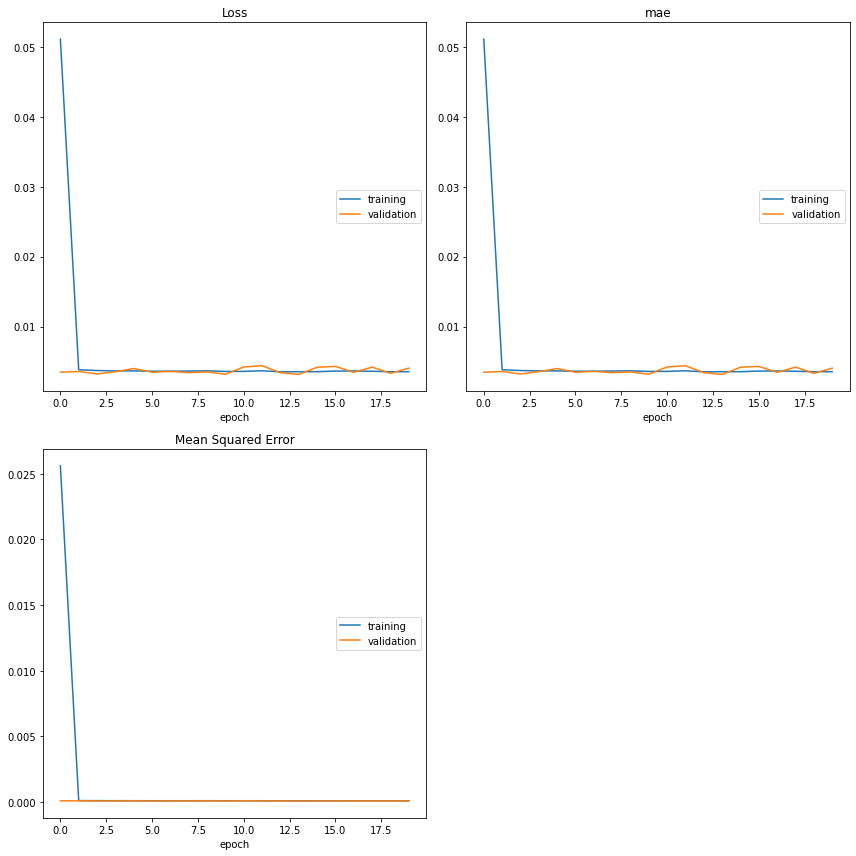

Loss
	training         	 (min:    0.004, max:    0.051, cur:    0.004)
	validation       	 (min:    0.003, max:    0.004, cur:    0.004)
mae
	training         	 (min:    0.004, max:    0.051, cur:    0.004)
	validation       	 (min:    0.003, max:    0.004, cur:    0.004)
Mean Squared Error
	training         	 (min:    0.000, max:    0.026, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
1862/1862 [==============================] - 7s 4ms/step - loss: 0.0035 - mae: 0.0035 - mse: 9.9266e-05 - val_loss: 0.0040 - val_mae: 0.0040 - val_mse: 8.7650e-05


In [8]:
# Overfitting analisys

#Our best model (remember we set refit
best_mlp_model = grid_search.best_estimator_

from livelossplot import PlotLossesKerasTF
best_mlp_model.fit(X_train, y_train, epochs=20,
validation_data=(X_test, y_test),
callbacks=[PlotLossesKerasTF()], verbose=1)

### Análise de overfitting

Pelos gráficos, vemos que o medium average error (mae) dá bastante mal, mas o mse dá bem. Como 20 epochs é um valor considerável, consideramos nesta fase melhorar o tratamento de dados, e depois verificar se há melhorias. 
Isto porque, o tratamento de dados atual para este modelo é quase com o objetivo de o modelo consiguir analisar o dataset.

In [9]:
 #0btain predictions


predictions = best_mlp_model.predict(X_test)


predictions = unscale(predictions)
y_test = unscale(y_test)
#pd.DataFrame(y_test).hist(figsize=(14, 14));
#pd.DataFrame(predictions).hist(figsize=(14, 14));

#y_test_scaled = unscale(y_test)


466/466 [==============================] - 1s 2ms/step


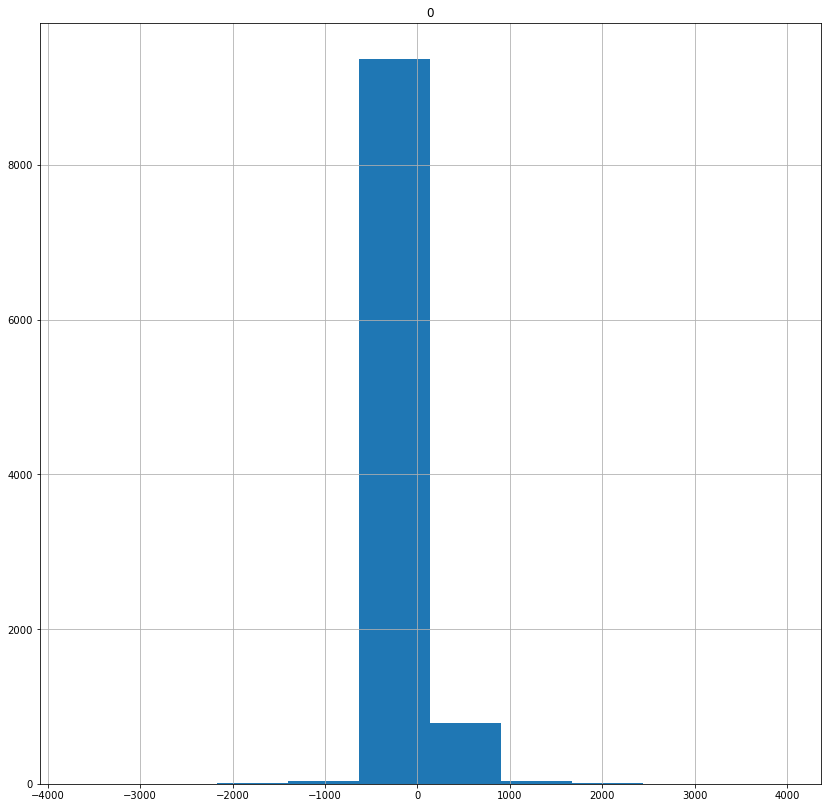

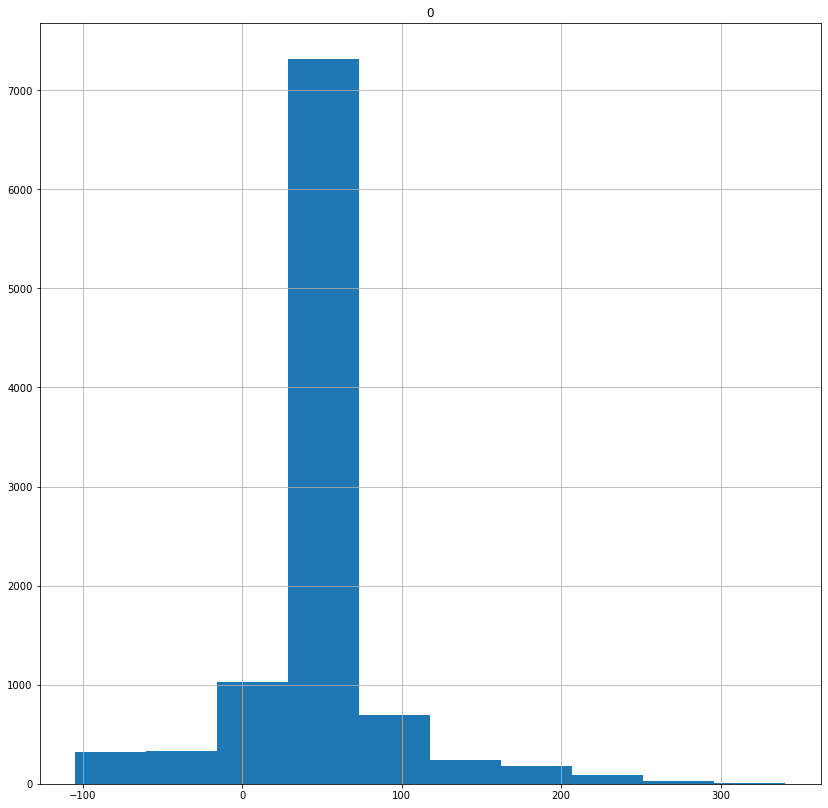

In [10]:
pd.DataFrame(y_test).hist(figsize=(14, 14));
pd.DataFrame(predictions).hist(figsize=(14, 14));


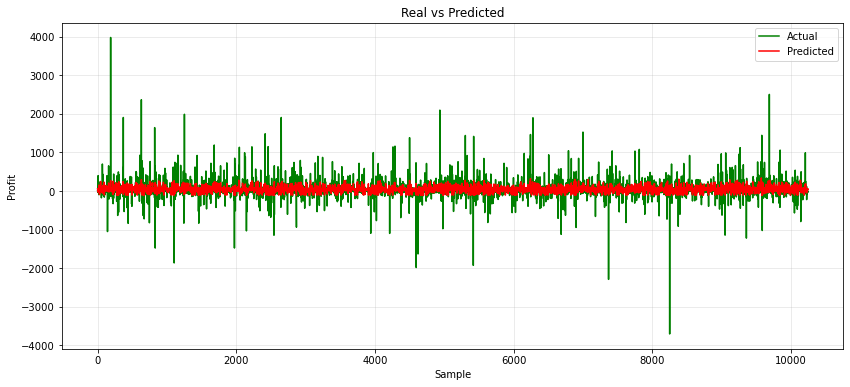

In [11]:


#Visualising the actual and predicted result
def real_predicted_viz(limit):
    plt.figure(figsize=(14,6))
    plt.plot(y_test, color = 'green', label = 'Actual')
    plt.plot (predictions, color = 'red', label = 'Predicted')
    plt.grid(alpha = 0.3)
    plt.xlabel('Sample')
    plt.ylabel ('Profit')
    plt.title('Real vs Predicted')
    plt.legend()
    plt.show()

#let's Limit to 200 comparisions for better visualization
real_predicted_viz(400)


Pela análise do gráfico, podemos ver que há algumas previsões aproximadamente corretas, mas existem algumas, bem visíveis, que mostram quão errado o nosso modelo está.
No entanto

In [12]:

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Média: %f Desvio padrão: (%f) com: %r" % (mean, stdev, param))


Best: -0.003689 using {'activation': 'relu', 'learning_rate': 0.01}
Média: -0.003689 Desvio padrão: (0.000230) com: {'activation': 'relu', 'learning_rate': 0.01}
Média: -0.004917 Desvio padrão: (0.000530) com: {'activation': 'relu', 'learning_rate': 0.03}
Média: -0.010794 Desvio padrão: (0.006146) com: {'activation': 'relu', 'learning_rate': 0.1}
Média: -0.285646 Desvio padrão: (0.279358) com: {'activation': 'sigmoid', 'learning_rate': 0.01}
Média: -0.285334 Desvio padrão: (0.279671) com: {'activation': 'sigmoid', 'learning_rate': 0.03}
Média: -0.565039 Desvio padrão: (0.000034) com: {'activation': 'sigmoid', 'learning_rate': 0.1}


In [13]:
#tf.keras.losses.mean_absolute_error(y_test_unscaled, predicions_unscaled)
mae = tf.keras.losses.MeanAbsoluteError()
print("MAE: ", mae(y_test, predictions).numpy())
#mse = tf.keras.losses.mean_squared_error(y_test_unscaled, predicions_unscaled).numpy()
mse = np.mean(np.square(y_test - predictions))
print("MSE: ", mse)
print("RMSE: ", math.sqrt(mse))

MAE:  60.86748
MSE:  19774.35181208006
RMSE:  140.62130639444388
